# Vector-Quantized Variational Autoencoders

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/21<br>
**Last modified:** 2021/07/21<br>
**Description:** Training a VQ-VAE for image reconstruction and codebook sampling for generation.

In this example, we will develop a Vector Quantized Variational Autoencoder (VQ-VAE).
VQ-VAE was proposed in
[Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)
by van der Oord et al. In traditional VAEs, the latent space is continuous and is sampled
from a Gaussian distribution. It is generally harder to learn such a continuous
distribution via gradient descent. VQ-VAEs, on the other hand,
operate on a discrete latent space, making the optimization problem simpler. It does so
by maintaining a discrete *codebook*. The codebook is developed by
discretizing the distance between continuous embeddings and the encoded
outputs. These discrete code words are then fed to the decoder, which is trained
to generate reconstructed samples.

For a detailed overview of VQ-VAEs, please refer to the original paper and
[this video explanation](https://www.youtube.com/watch?v=VZFVUrYcig0).
If you need a refresher on VAEs, you can refer to
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/).
VQ-VAEs are one of the main recipes behind [DALL-E](https://openai.com/blog/dall-e/)
and the idea of a codebook is used in [VQ-GANs](https://arxiv.org/abs/2012.09841).

This example uses references from the
[official VQ-VAE tutorial](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb)
from DeepMind. To run this example, you will need TensorFlow 2.5 or higher, as well as
TensorFlow Probability, which can be installed using the command below.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

## `VectorQuantizer` layer

Here, we will implement a custom layer to encapsulate the vector
quantizer logic, which is the central component of VQ-VAEs.
Consider an output from the encoder, with shape `(batch_size, height, width, num_channels)`.
The vector quantizer will first
flatten this output, only keeping the `num_channels` dimension intact. So, the shape would
become `(batch_size * height * width, num_channels)`. The rationale behind this is to
treat the total number of channels as the space for the latent embeddings.

An embedding table is then initialized to learn a codebook. We measure the L2-normalized
distance between the flattened encoder outputs and code words of this codebook. We take the
code that yields the minimum distance, and we apply one-hot encoding to achieve quantization.
This way, the code yielding the minimum distance to the corresponding encoder output is
mapped as one and the remaining codes are mapped as zeros.

Since the quantization process is not differentiable, we apply a
[straight-through estimator](https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html)
in between the decoder and the encoder, so that the decoder gradients are directly propagated
to the encoder. As the encoder and decoder share the same channel space, the hope is that the
decoder gradients will still be meaningful to the encoder.

In [2]:

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


**A note on straight-through estimation**:

This line of code does the straight-through estimation part: `quantized = x +
tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be
included in the computation graph and th gradients obtaind for `quantized`
will be copied for `inputs`. Thanks to [this video](https://youtu.be/VZFVUrYcig0?t=1393)
for helping me understand this technique.

## Encoder and decoder

We will now implement the encoder and the decoder for the VQ-VAE. We will keep them small so
that their capacity is a good fit for the MNIST dataset, which we will use to demonstrate
the results. The definitions of the encoder and decoder come from
[this example](https://keras.io/examples/generative/vae).

In [3]:

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


## Standalone VQ-VAE model

In [4]:

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

2022-06-20 14:44:35.091386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


Note that the output channels of the encoder should match the `latent_dim` for the vector
quantizer.

## Wrapping up the training loop inside `VQVAETrainer`

In [5]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


## Load and preprocess the MNIST dataset

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

## Train the VQ-VAE model

In [7]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 48s 100ms/step - loss: 2.5219 - reconstruction_loss: 0.3703 - vqvae_loss: 1.8310
Epoch 2/30
469/469 [==============================] - 47s 101ms/step - loss: 2.0697 - reconstruction_loss: 0.1552 - vqvae_loss: 1.9058
Epoch 3/30
469/469 [==============================] - 45s 96ms/step - loss: 1.0316 - reconstruction_loss: 0.1171 - vqvae_loss: 0.9059
Epoch 4/30
469/469 [==============================] - 44s 93ms/step - loss: 0.5531 - reconstruction_loss: 0.0979 - vqvae_loss: 0.4509
Epoch 5/30
469/469 [==============================] - 47s 100ms/step - loss: 0.3945 - reconstruction_loss: 0.0833 - vqvae_loss: 0.3084
Epoch 6/30
469/469 [==============================] - 46s 99ms/step - loss: 0.3463 - reconstruction_loss: 0.0750 - vqvae_loss: 0.2695
Epoch 7/30
469/469 [==============================] - 44s 95ms/step - loss: 0.3114 - reconstruction_loss: 0.0698 - vqvae_loss: 0.2403
Epoch 8/30
469/469 [==============================] - 45s 9

## Reconstruction results on the test set

1/1 [==============================] - 0s 194ms/step


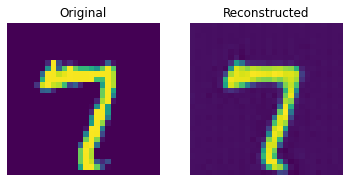

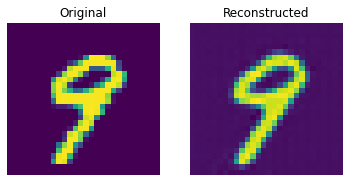

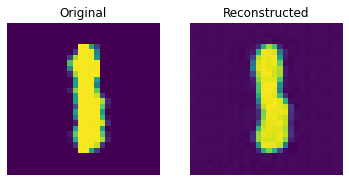

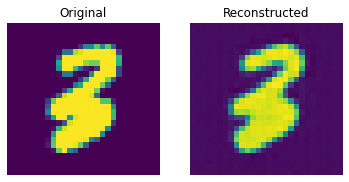

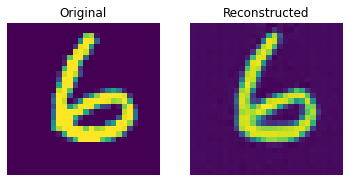

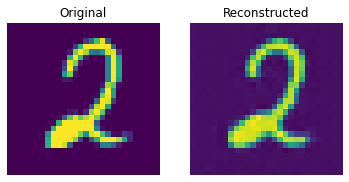

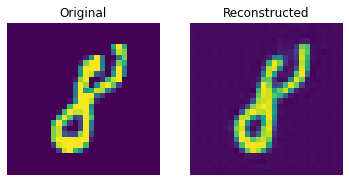

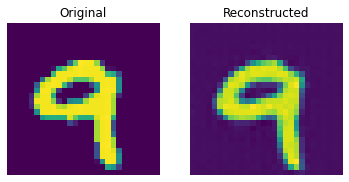

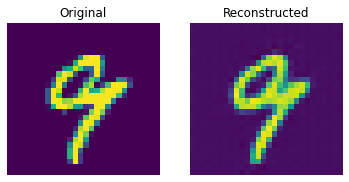

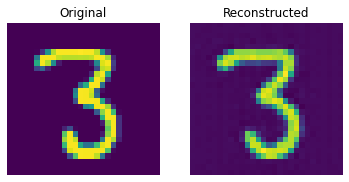

In [8]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

These results look decent. You are encouraged to play with different hyperparameters
(especially the number of embeddings and the dimensions of the embeddings) and observe how
they affect the results.

## Visualizing the discrete codes

1/1 [==============================] - 0s 49ms/step


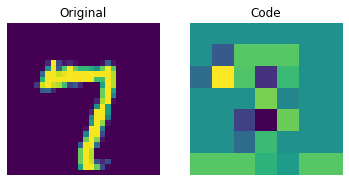

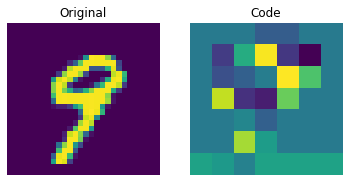

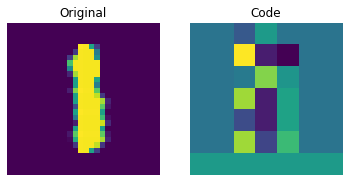

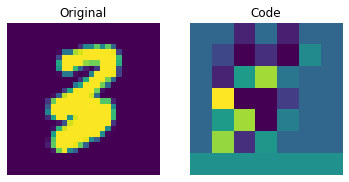

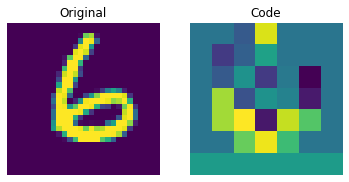

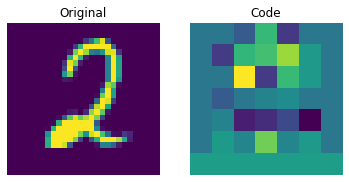

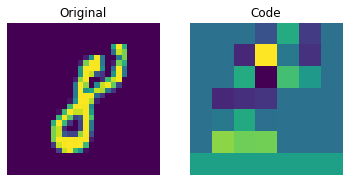

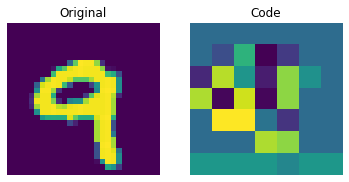

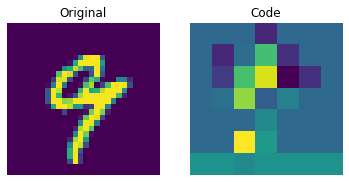

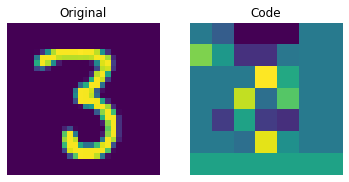

In [9]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

The figure above shows that the discrete codes have been able to capture some
regularities from the dataset. Now, you might wonder, ***how do we use these codes to
generate new samples?*** Specifically, how do we sample from this codebook to create
novel examples? Since these codes are discrete and we imposed a categorical distribution
on them, we cannot use them yet to generate anything meaningful. These codes were not
updated during the training process as well. So, they need to be adjusted further so that
we can use for them the subsequent image generation task. The authors use a PixelCNN to
train these codes so that they can be used as powerful priors to generate novel examples.

PixelCNN was proposed in
[Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
by van der Oord et al. We will borrow code from
[this example](https://keras.io/examples/generative/pixelcnn/)
to develop a PixelCNN. It's an auto-regressive generative model where the current outputs
are conditioned on the prior ones. In other words, a PixelCNN generates an image on a
pixel-by-pixel basis.

## PixelCNN hyperparameters

In [10]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


Don't worry about the input shape. It'll become clear in the following sections.

## PixelCNN model

Majority of this comes from
[this example](https://keras.io/examples/generative/pixelcnn/).

In [11]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 7, 7, 128)        802944    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 7, 7, 128)        98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 7, 7, 128)        98624     
 lock)                                                           
                                                         

## Prepare data to train the PixelCNN

We will train the PixelCNN to learn a categorical distribution of the discrete codes.
First, we will generate code indices using the encoder and vector quantizer we just
trained. Our training objective will be to minimize the crossentropy loss between these
indices and the PixelCNN outputs. Here, the number of categories is equal to the number
of embeddings present in our codebook (128 in our case). The PixelCNN model is
trained to learn a distribution (as opposed to minimizing the L1/L2 loss), which is where
it gets its generative capabilities from.

In [12]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 3s 1ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


## PixelCNN training

In [13]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
422/422 [==============================] - 107s 252ms/step - loss: 1.9301 - accuracy: 0.5558 - val_loss: 1.3533 - val_accuracy: 0.6106
Epoch 2/30
422/422 [==============================] - 102s 242ms/step - loss: 1.2750 - accuracy: 0.6244 - val_loss: 1.2381 - val_accuracy: 0.6309
Epoch 3/30
422/422 [==============================] - 104s 246ms/step - loss: 1.2008 - accuracy: 0.6374 - val_loss: 1.1882 - val_accuracy: 0.6398
Epoch 4/30
422/422 [==============================] - 101s 238ms/step - loss: 1.1620 - accuracy: 0.6443 - val_loss: 1.1655 - val_accuracy: 0.6426
Epoch 5/30
422/422 [==============================] - 97s 230ms/step - loss: 1.1360 - accuracy: 0.6493 - val_loss: 1.1481 - val_accuracy: 0.6468
Epoch 6/30
422/422 [==============================] - 102s 241ms/step - loss: 1.1169 - accuracy: 0.6531 - val_loss: 1.1346 - val_accuracy: 0.6487
Epoch 7/30
422/422 [==============================] - 97s 229ms/step - loss: 1.1020 - accuracy: 0.6561 - val_loss: 1.1301 - v

We can improve these scores with more training and hyperparameter tuning.

## Codebook sampling

Now that our PixelCNN is trained, we can sample distinct codes from its outputs and pass
them to our decoder to generate novel images.

In [14]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
x = pixel_cnn(inputs, training=False)
dist = tfp.distributions.Categorical(logits=x)
sampled = dist.sample()
sampler = keras.Model(inputs, sampled)

We now construct a prior to generate images. Here, we will generate 10 images.

In [15]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 21ms/step
Prior shape: (10, 7, 7)


We can now use our decoder to generate the images.

1/1 [==============================] - 0s 75ms/step


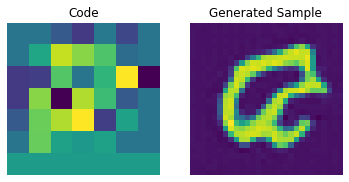

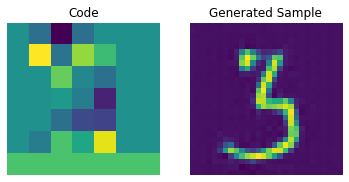

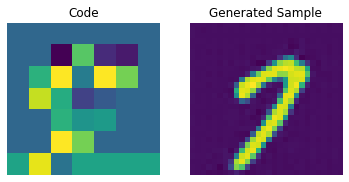

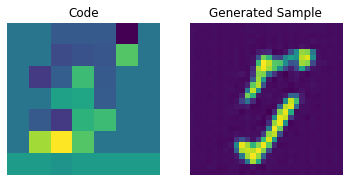

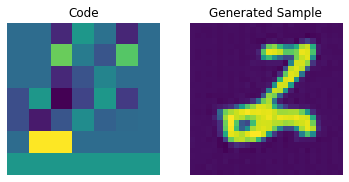

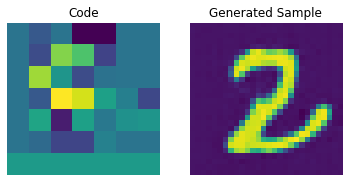

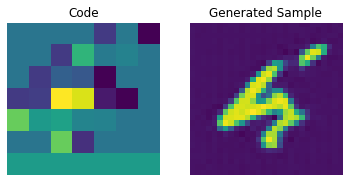

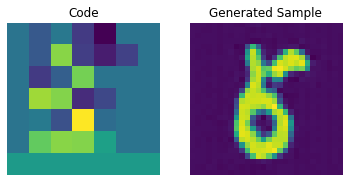

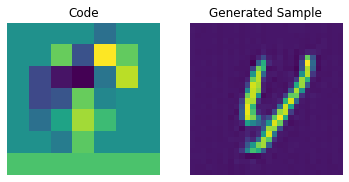

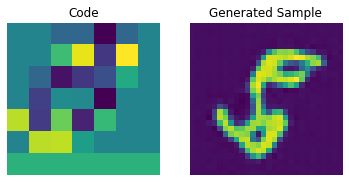

In [16]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

We can enhance the quality of these generated samples by tweaking the PixelCNN.

## Additional notes

* After the VQ-VAE paper was initially released, the authors developed an exponential
moving averaging scheme to update the embeddings inside the quantizer. If you're
interested you can check out
[this snippet](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py#L124).
* To further enhance the quality of the generated samples,
[VQ-VAE-2](https://arxiv.org/abs/1906.00446) was proposed that follows a cascaded
approach to learn the codebook and to generate the images.